# NHS Winter SitRep

Notebook starting to explore NHS Winter Sitrep Data

## Harvesting

One frequently encountered task when working with regularly produced datasets is the downloading of 'latest release' spreadsheet or CSV data files. These can typically take one of three forms:

- a new weekly or monthly file is released containing just the figures for that week or month;
- a refreshed release of the current state of an often time-sensitive dataset. For example, a list of current roadworks where no historical data is accessible
- an updated longitudinal dataset that contains historical data, organised by date/time, as well as the most recent data.

In each case, there is a requirement to regularly download the newly released file. In the first case, when starting a longitudinal analysis, there may be a requirement to download historical data files (the monthly releases for previous months, for example) from which a longitudinal dataset may be created.

Harvesting data refers to the collection of data from a known location. Harvesting may occur over time, for example, according a schedule - collecting a monhtly dataset when it has been published - or collecting a set of data from multiple files or locations in order to seed a larger data set.

Where regularly released datafiles are posted to a known web location with a long lived URL in the form of a link on that page to the datafile itself, possibly along with a sef of previously posted links to historical datasets, we can often automate the collection of the data by scraping the links to the datafile or datafiles and then using those links as the basis of an automatic download

### Simple Screenscraper and Link Harvester

In [75]:
#This set of routines downloads data files from the NHS Statistics website

import pandas as pd

#requests is a library that simplifies grabbing web pages and downloading files from web addresses / URLs
import requests

#BeautifulSoup is a library that helps parse HTML web pages and XML files
from bs4 import BeautifulSoup 

#The os library lets us poke around to see what files we have
import os

def _make_filename(link):
    return link.split('/')[-1]

def _getLinksFromPage(url):
    
    page = requests.get(url)

    #The file we have grabbed in his case is a web page - that is, an HTML file
    #We can get the content of the page and parse it
    soup=BeautifulSoup(page.content, "html5lib")
    #BeautifulSoup has a routine - find_all() - that will find all the HTML tags of a particular sort
    #Links are represented in HTML pages in the form <a href="http//ecample.com/page.html">link text</a>
    #Grab all the <a> (anchor) tags...
    souplinks=soup.find_all('a')
    #links=[link.get('href') for link in souplinks]
    return souplinks

##Via http://stackoverflow.com/a/16696317/454773
#TH - added path
#The following function seems to be a pretty robust, generic function, for downloading an arbitrary file to our local machine
def _download_file(url,path):
    ''' Download a file from a particular URL to the current directory with original filename '''
    local_filename = _make_filename(url)
    local_filename='/'.join([path,local_filename])
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
    return local_filename

def download_files_linked_from_url(url,datadir,filetype=None):
    if filetype is None: filetype='csv'
    if not os.path.exists(datadir):
        #I assume that python has permissions to create directories and save files?
        os.makedirs(datadir)

    #Check datadir to see what files we have
    cachefiles=os.listdir(datadir)
    
    links = _getLinksFromPage(url)
    #print(links)
    if links is None: return
    
    #We can iterate through all the links one at a time, calling each link "link" temporarily as we do so
    for link in links:
        #Do a logical test to see if the linked URL has the desired suffix
        if link['href'].endswith('.{filetype}'.format(filetype=filetype)):
            #If the link does look like its a link to a file of the required type
            # extract the filename
            fn= _make_filename(link['href'])
            #If we haven't already downloaded the file...
            if fn not in cachefiles:
                #Download it...
                fn=_download_file(link['href'],datadir)
                print("Downloaded {}".format(fn))
            else:
                print("Already downloaded {}".format(fn))
                
def download_NHS_reports(typ,datadir='.',filetype=None):
    url=''
    if typ=='sitrep':
        url='https://www.england.nhs.uk/statistics/statistical-work-areas/winter-daily-sitreps/winter-daily-sitrep-2017-18-data/'
        #url='https://www.england.nhs.uk/statistics/statistical-work-areas/winter-daily-sitreps/winter-daily-sitrep-2016-17-data/'#'http://www.england.nhs.uk/statistics/statistical-work-areas/winter-daily-sitreps/winter-daily-sitrep-2014-15-data/'
    if url!='':
        download_files_linked_from_url(url,datadir,filetype)
    

In [76]:
download_NHS_reports('sitrep',datadir='sitrep',filetype='xlsx')

Already downloaded Winter-data-Timeseries-20171231.xlsx
Already downloaded 111-for-winter-daily-sitrep-up-to-20171231-unlinked.xlsx
Already downloaded Winter-data-20171231.xlsx
Already downloaded Winter-data-20171224.xlsx
Already downloaded Winter-data-20171217.xlsx
Already downloaded Winter-data-week-commencing-20171204.xlsx
Already downloaded Winter-data-we-3-Dec-v2.xlsx
Already downloaded Winter-data-we-26-Nov-Updated-20171221.xlsx


## Parsing Complex Spreadsheets

When working with third party spreadsheets, it is not uncommon to find layouts that include metadata elements in the first sheet or at the top of a sheet, hierarchically declared column headings, where for example a heading spans several columns in one rows and is then subdivided into subheadings that appear in the next row, footnotes that appear at the bottom of a spreadsheet and even sidenotes that are pasted into additional columns.

Even simpler CSV files may include hierarchical indices and leading and trailing metadata or additional notes.


These routines parse the data contained in the NHS Winter Sitrep spreadsheet worksheets into *pandas* datatables.

In [77]:
import pandas as pd
def DailySR_read(f):
    return pd.ExcelFile(f)

xl=DailySR_read('sitrep/Winter-data-Timeseries-20171231.xlsx')
reports = [n for n in  xl.sheet_names if n !='Macro1']
reports

['A&E closures',
 'A&E diverts',
 'G&A beds',
 'Beds Occ by long stay patients',
 'D&V, Norovirus',
 'Adult critical care',
 'Paediatric intensive care',
 'Neonatal intensive care ',
 'Ambulance Arrivals and Delays']

In [78]:
def DailySR_parse(xl,sheet,skiprows=13,header=None):
    #In the spredsheet, there are two types of sheet that differ in header treatment
    xlclass={'A&E closures':0,
             'A&E diverts':0,
             'G&A beds':1,
             'Beds Occ by long stay patients':1,
             'D&V, Norovirus':1,
             'Adult critical care':1,
             'Paediatric intensive care':1,
             'Neonatal intensive care ':1,
             'Ambulance Arrivals and Delays':1,#,
             #'Macro1':-1
             }
    if sheet not in xlclass: return pd.DataFrame()
    
    dfx=xl.parse(sheet,skiprows=skiprows,header=header)
    dfx.dropna(how='all',inplace=True)
    dfx.dropna(how='all',axis=1,inplace=True)
    cols=[]

    if xlclass[sheet]==0:
        dfx.drop([2,3],inplace=True)
        dfx.dropna(how='all',axis=1,inplace=True)
        dfx.columns=dfx.iloc[0].values
        dfx=dfx[1:]
        #Transpose rows and columns
        dfx=dfx.T
        #Set the column names
        dfx.columns=pd.MultiIndex.from_arrays(dfx[:3].values, names=['Area','Code','Name']) 
        #And then throw away the metadata rows used to create columns headers
        dfx=dfx[3:]
        #Cast cols to numeric
        dfx = dfx.apply(pd.to_numeric, errors='ignore')
        dfx = pd.melt(dfx.reset_index(),id_vars=['index'])
        dfx['value'] = pd.to_numeric(dfx['value'],errors='coerce')
        dfx.columns = ['Date']+dfx.columns[1:].tolist()
        dfx['Category']=sheet
        dfx['Report']=sheet
    elif xlclass[sheet]==1:
        #This is a real hack, trying to think what a sensible shape is and how to get there
        #Drop an empty row and the total count for England row
        dfx.drop([2,3],inplace=True)
        dfx.dropna(how='all',axis=0,inplace=True)
        #Get rid of empty columns
        dfx.dropna(how='all',axis=1,inplace=True)
        #Fill across on dates
        dfx.iloc[0] = dfx.iloc[0].fillna(method='ffill')
        #Patch the leading empty columns
        dfx.loc[:1] = dfx.loc[:1].fillna('Metadata')
        #Generate a multi-index across the columns from the first two rows
        ##TO DO
        #Some of the dates are dates (weekdays) and correctly get parsed as dates
        #Others are periods (over a weekend) and need handling somehow
        #May be best to convert them to dates corresponding to last date in period?
        #  Then perhaps also build a small helper that searches on a date and 
        #  if it falls into weekend period, rewrite it as the last date in the period?
        dfx.columns=pd.MultiIndex.from_arrays(dfx.iloc[:2].values, names=['Date','Category'])
        #Drop the rows we used to make the multi-index
        dfx=dfx[2:]
        #Transpose rows and columns
        dfx=dfx.T
        #Set the column names
        dfx.columns=pd.MultiIndex.from_arrays(dfx[:3].values, names=['Area','Code','Name'])
        #And then throw away the metadata rows used to create columns headers
        dfx=dfx[3:]
        #Tidy up by throwing away any empty columns we created
        dfx.dropna(how='all',axis=1,inplace=True)
        dfx = pd.melt(dfx.reset_index(),id_vars=['Date','Category'])
        #Cast value to numeric
        dfx['value'] = pd.to_numeric(dfx['value'],errors='coerce')
        dfx['Report']=sheet
    return dfx


#TO DO
#Function that will load in all appropriate files to date to give a single monolithic dataframe
#covering all the reports



#Probably makes sense to just dump the spreadsheet into a simple sqlite database?
#import sqlite3
 
#conn = sqlite3.connect('test.db')
#xx.to_sql('test1', conn)
#pd.read_sql_query("select * from test1  limit 5;", conn)

def get_report(xl,sheet):
    return DailySR_parse(xl,sheet)

report=get_report(xl,'G&A beds')
report[:10]

,Date,Category,Area,Code,Name,value,Report
0,2017-11-20,Core Beds Open,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",911.000000,G&A beds
1,2017-11-20,Escalation Beds Open,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0.000000,G&A beds
2,2017-11-20,Total Beds Open,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",911.000000,G&A beds
3,2017-11-20,Total beds occ'd,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",900.000000,G&A beds
4,2017-11-20,Occupancy rate,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0.987925,G&A beds
5,2017-11-21,Core Beds Open,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",911.000000,G&A beds
6,2017-11-21,Escalation Beds Open,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0.000000,G&A beds
7,2017-11-21,Total Beds Open,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",911.000000,G&A beds
8,2017-11-21,Total beds occ'd,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",906.000000,G&A beds
9,2017-11-21,Occupancy rate,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0.994512,G&A beds


In [79]:
report2=get_report(xl,'A&E diverts')
report2[:10]

,Date,Area,Code,Name,value,Category,Report
0,2017-11-20,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E diverts,A&E diverts
1,2017-11-21,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E diverts,A&E diverts
2,2017-11-22,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E diverts,A&E diverts
3,2017-11-23,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E diverts,A&E diverts
4,2017-11-24,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E diverts,A&E diverts
5,2017-11-25,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E diverts,A&E diverts
6,2017-11-26,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E diverts,A&E diverts
7,2017-11-27,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E diverts,A&E diverts
8,2017-11-28,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E diverts,A&E diverts
9,2017-11-29,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E diverts,A&E diverts


In [80]:
%matplotlib inline

In [81]:
def timeSeriesPlot(df,time='Date',val='value',title=''):
    df.set_index('Date')['value'].plot(title=title)

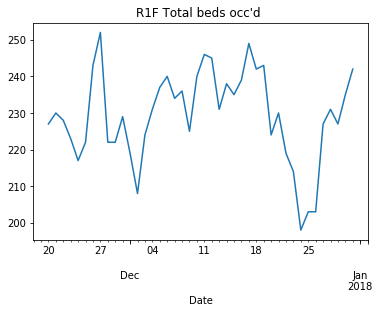

In [82]:
tmp = report[(report['Code']=='R1F') & (report['Category']=="Total beds occ'd")]
timeSeriesPlot(tmp,title="R1F Total beds occ'd ")

In [83]:
def timeSeriesSelectPlot(report=None, reportname=None,category=None,code=None,time='Date',val='value',title=None):
    if report is None: return
    #df=DailySR_parse(xl,report)
    df=report
    tmp = df[(df['Code']==code) & (df['Category']==category)]
    
    if title is None: 
        title = "{} - {} for {}".format(reportname,category,code)
        
    timeSeriesPlot(tmp,title=title)

In [84]:
reports

['A&E closures',
 'A&E diverts',
 'G&A beds',
 'Beds Occ by long stay patients',
 'D&V, Norovirus',
 'Adult critical care',
 'Paediatric intensive care',
 'Neonatal intensive care ',
 'Ambulance Arrivals and Delays']

In [85]:
reportname = 'Beds Occ by long stay patients'

report = get_report(xl,reportname)

In [86]:
def reportItems(report):
    return report['Category'].unique().tolist()

def reportNameItems(xl,reportname):
    report = get_report(xl,reportname)
    return report['Category'].unique().tolist()

In [87]:
reportItems(report)

['> 7 days', '> 21 days']

In [88]:
reportNameItems(xl,reportname)

['> 7 days', '> 21 days']

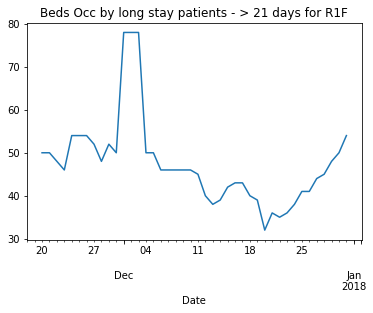

In [89]:
timeSeriesSelectPlot(report,reportname,category='> 21 days',code='R1F')

## SQLise...

Let's put everything into a SQLite database, and then we can start to query it using SQL.

In [92]:
#Probably makes sense to just dump the spreadsheet into a simple sqlite database?
import sqlite3

#!rm nhs_wintersitrep.db

conn = sqlite3.connect('nhs_wintersitrep.db')

df= pd.DataFrame()
for reportname in reports:
    report = get_report(xl,reportname)
    report.to_sql('sitrep', conn, index=False, if_exists='append')
    

In [93]:
pd.read_sql_query("select * from sitrep limit 5;", conn)


,Date,Area,Code,Name,value,Category,Report
0,2017-11-20 00:00:00,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E closures,A&E closures
1,2017-11-21 00:00:00,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E closures,A&E closures
2,2017-11-22 00:00:00,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E closures,A&E closures
3,2017-11-23 00:00:00,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E closures,A&E closures
4,2017-11-24 00:00:00,London Commissioning Region,RF4,"Barking, Havering And Redbridge University Hos...",0,A&E closures,A&E closures


For example, via @carlbaker, I see this:

![](https://pbs.twimg.com/media/DSr_wHqW0AMxwzE.png)

Let's get a count of the delayed ambulances, by Trust, within that period:

In [94]:
q='''
SELECT  Name, SUM(value) FROM sitrep 
WHERE date(Date) BETWEEN date('2017-12-25') AND date('2017-12-31') 
AND (Category = 'Delay >60 mins' OR Category='Delay 30-60 mins') AND value NOT NULL GROUP BY Name ORDER BY SUM(value) DESC
;
'''

pd.read_sql_query(q, conn).head()

,Name,SUM(value)
0,East Kent Hospitals University NHS Foundation ...,585
1,Worcestershire Acute Hospitals NHS Trust,413
2,East Lancashire Hospitals NHS Trust,391
3,Lancashire Teaching Hospitals NHS Foundation T...,390
4,United Lincolnshire Hospitals NHS Trust,373


We can also find the total number of arrivals for each Trust in the same period:

In [95]:
q2='''
SELECT  Name, SUM(value) FROM sitrep 
WHERE date(Date) BETWEEN date('2017-12-25') AND date('2017-12-31') 
AND Category = 'Arriving by ambulance'  AND value NOT NULL GROUP BY Name ORDER BY SUM(value) DESC
;
'''

pd.read_sql_query(q2, conn).head()


,Name,SUM(value)
0,Barts Health NHS Trust,1783
1,Pennine Acute Hospitals NHS Trust,1699
2,Heart Of England NHS Foundation Trust,1535
3,Leeds Teaching Hospitals NHS Trust,1429
4,Frimley Health NHS Foundation Trust,1402


Now we can combine those and find the percentage of total arrivials to each Trust that were delayed, ordering from most delayed.

In [96]:
q3='''
SELECT total.Name, Delayed, Total, 100.0*Delayed/Total AS pc FROM (SELECT  Name, SUM(value) AS Delayed FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND (Category = 'Delay >60 mins' OR Category='Delay 30-60 mins') 
AND value NOT NULL GROUP BY Name) delayed JOIN (SELECT  Name, SUM(value) AS Total FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND Category = 'Arriving by ambulance' AND value NOT NULL GROUP BY Name) total on total.Name = delayed.Name 
ORDER BY pc DESC
'''.format(fromdate='2017-12-25', todate='2017-12-31')
pd.read_sql_query(q3, conn).head(10)

,Name,Delayed,Total,pc
0,"The Queen Elizabeth Hospital, King's Lynn, NHS...",239,418,57.177033
1,Lancashire Teaching Hospitals NHS Foundation T...,390,724,53.867403
2,East Lancashire Hospitals NHS Trust,391,890,43.932584
3,East Kent Hospitals University NHS Foundation ...,585,1350,43.333333
4,Sherwood Forest Hospitals NHS Foundation Trust,274,637,43.014129
5,Portsmouth Hospitals NHS Trust,321,753,42.629482
6,Mid Essex Hospital Services NHS Trust,243,592,41.047297
7,Kettering General Hospital NHS Foundation Trust,240,618,38.834951
8,Worcestershire Acute Hospitals NHS Trust,413,1103,37.443336
9,The Dudley Group NHS Foundation Trust,344,951,36.172450


Let's compare:

![](https://pbs.twimg.com/media/DSr_wHqW0AMxwzE.png)

That display is maybe  not so useful though, becuase the population sizes differ. We really need something along the lines of a [funnel plot](https://blog.ouseful.info/2011/10/31/power-tools-for-aspiring-data-journalists-r/), but for now let's stick with a scatter plot withouth any distribution guide lines to see if there are any outliers:

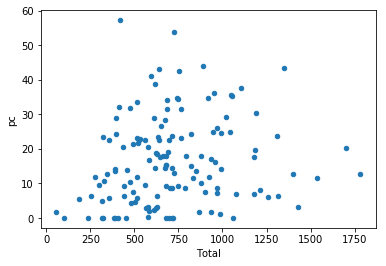

In [99]:
pd.read_sql_query(q3, conn).plot(kind='scatter', x='Total',y='pc')

Another quick view gives a head up to where there are numerically lots of delays...

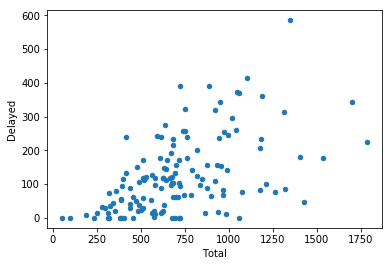

In [100]:
pd.read_sql_query(q3, conn).plot(kind='scatter', x='Total',y='Delayed')

Here's another - Bed Occupancy:

![](https://pbs.twimg.com/media/DSsDvgMW4AATHKK.png)

But how do we calculate this? The average of the occupancy rates over the week?

Which data sheet(s) does the data come from and how is it analysed to generate that table?

For example, what if we naively just try to take the average of the rates for each trust over the week?

In [74]:
q4='''
SELECT Name, 100*AVG(value) AS av FROM sitrep 
WHERE date(Date) BETWEEN date('{fromdate}') AND date('{todate}') 
AND Category = "Occupancy rate" GROUP BY Name
ORDER BY av DESC
'''.format(fromdate='2017-12-25', todate='2017-12-31')
pd.read_sql_query(q4, conn).head(10)

,Name,av
0,Weston Area Health NHS Trust,96.274174
1,James Paget University Hospitals NHS Foundatio...,96.191210
2,Harrogate And District NHS Foundation Trust,95.764972
3,University Hospitals Birmingham NHS Foundation...,95.652122
4,St Helens And Knowsley Hospital Services NHS T...,95.351082
5,King's College Hospital NHS Foundation Trust,94.762360
6,North Middlesex University Hospital NHS Trust,94.109607
7,Nottingham University Hospitals NHS Trust,93.903388
8,Countess Of Chester Hospital NHS Foundation Trust,93.614342
9,North Cumbria University Hospitals NHS Trust,93.088257


This is why I think research reports need to show their working or at least have the working available...

## Isle of Wight Report

General reports for Isle of Wight.

In [21]:
code='R1F'

df= pd.DataFrame()
for reportname in reports:
    report = get_report(xl,reportname)
    report['ReportCategory']=report['Report']+'_'+report['Category']
    #for reportItem in reportItems(report):
    df = pd.concat([df,report[(report['Code']==code)][['Date','ReportCategory','value']]])
df.tail()

,Date,ReportCategory,value
14359,2017-12-30,Ambulance Arrivals and Delays_Delay 30-60 mins,3.0
14360,2017-12-30,Ambulance Arrivals and Delays_Delay >60 mins,1.0
14361,2017-12-31,Ambulance Arrivals and Delays_Arriving by ambu...,52.0
14362,2017-12-31,Ambulance Arrivals and Delays_Delay 30-60 mins,2.0
14363,2017-12-31,Ambulance Arrivals and Delays_Delay >60 mins,1.0


Make a wide version of the data

In [22]:
dfw = df.pivot( index='Date',columns='ReportCategory', values='value')
dfw.head()

ReportCategory,A&E closures_A&E closures,A&E diverts_A&E diverts,Adult critical care_CC Adult Occ,Adult critical care_CC Adult Open,Adult critical care_CC Adult avail,Adult critical care_Occupancy rate,Ambulance Arrivals and Delays_Arriving by ambulance,Ambulance Arrivals and Delays_Delay 30-60 mins,Ambulance Arrivals and Delays_Delay >60 mins,Beds Occ by long stay patients_> 21 days,...,G&A beds_Total Beds Open,G&A beds_Total beds occ'd,Neonatal intensive care _Neo Int Care Avail,Neonatal intensive care _Neo Int Care Occ,Neonatal intensive care _Neo Int Care Open,Neonatal intensive care _Occupancy rate,Paediatric intensive care_Occupancy rate,Paediatric intensive care_Paed Int Care Avail,Paediatric intensive care_Paed Int Care Occ,Paediatric intensive care_Paed Int Care Open
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-20,0.0,0.0,4.0,NaN,6.0,0.666667,49.0,4.0,0.0,50.0,...,245.0,227.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2017-11-21,0.0,0.0,4.0,NaN,6.0,0.666667,52.0,1.0,1.0,50.0,...,245.0,230.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2017-11-22,0.0,0.0,6.0,NaN,6.0,1.000000,45.0,0.0,1.0,48.0,...,245.0,228.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2017-11-23,0.0,0.0,4.0,NaN,6.0,0.666667,52.0,0.0,1.0,46.0,...,245.0,223.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2017-11-24,0.0,0.0,3.0,NaN,6.0,0.500000,46.0,1.0,3.0,54.0,...,245.0,217.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


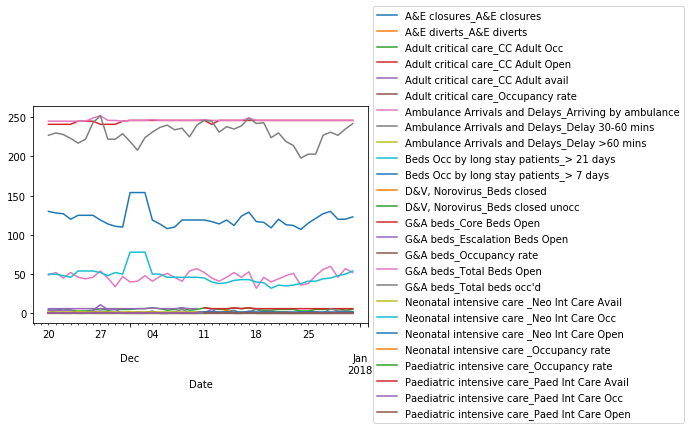

In [23]:
dfw.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5));

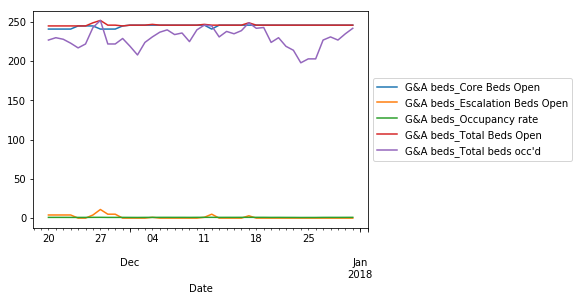

In [24]:
cols=[c for c in dfw.columns if 'G&A' in c]
dfw[cols].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5));

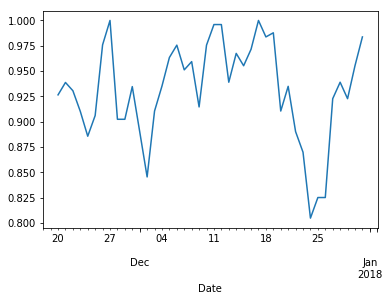

In [25]:
dfw['G&A beds_Occupancy rate'].plot()

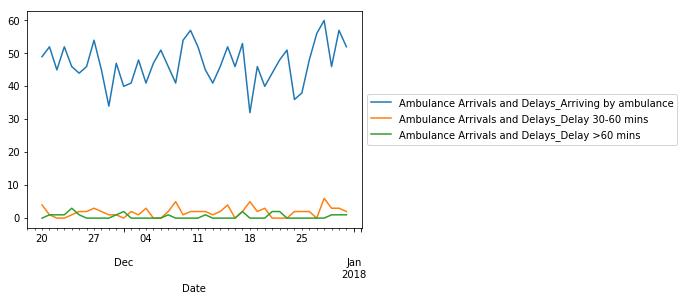

In [30]:
cols=[c for c in dfw.columns if 'Ambulance Arrivals' in c]
dfw[cols].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [31]:
cols

['Ambulance Arrivals and Delays_Arriving by ambulance',
 'Ambulance Arrivals and Delays_Delay 30-60 mins',
 'Ambulance Arrivals and Delays_Delay >60 mins']

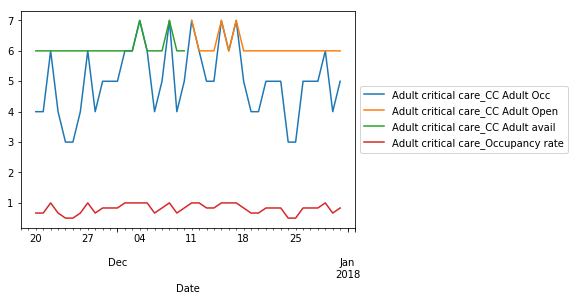

In [27]:
cols=[c for c in dfw.columns if 'Adult critical' in c]
dfw[cols].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [29]:
cols

['Adult critical care_CC Adult Occ',
 'Adult critical care_CC Adult Open',
 'Adult critical care_CC Adult avail',
 'Adult critical care_Occupancy rate']

In [28]:
dfw[cols].head()

ReportCategory,Adult critical care_CC Adult Occ,Adult critical care_CC Adult Open,Adult critical care_CC Adult avail,Adult critical care_Occupancy rate
Date,,,,
2017-11-20,4.0,NaN,6.0,0.666667
2017-11-21,4.0,NaN,6.0,0.666667
2017-11-22,6.0,NaN,6.0,1.000000
2017-11-23,4.0,NaN,6.0,0.666667
2017-11-24,3.0,NaN,6.0,0.500000
